<center><h1>TRAFFIC PREDICTION IN NETWORK</h1></center>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing,cross_validation,svm
from sklearn.linear_model import LinearRegression
import seaborn as sns
# example of making predictions for a regression problem
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import array
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from keras import losses
from datetime import datetime, timedelta

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Import dữ liệu
**Tính chất của dữ liệu:**
- Dữ liệu là thông tin về traffic của các cell 4G (Cell 4G là thiết bị phát sóng vô tuyến để phục vụ các thiết bị). Traffic của cell 4G được hiểu đơn giản như sau: Khi người dùng sử dụng dịch vụ data trên thiết bị di động, thì thiết bị di động đó sẽ được phục vụ bởi 1 cell 4G được đặt gần đó. Tổng dung lượng data của tất cả các người dùng được phục vụ bởi 1 cell trong vòng 1 giờ được gọi là Traffic của cell đó trong vòng 1 giờ. VD: Cell 039872 đang phục vụ cho 50 thuê bao, mỗi thuê bao trong 1 giờ x sử dụng trung bình 10Mb => Traffic của cell 039872. Vậy traffic của cell này trong giờ x = 50 * 10 = 500Mb.
- Tập dữ liệu có: 57 cell
- Dữ liệu được lấy trong vòng xấp xỉ 1 năm x 24 giờ x 57 cell.
- Tính chất của traffic sẽ có sự khác nhau theo từng giờ (VD: vào khoảng thời gian 10-12h và 19-23h traffic sẽ rất cao, 0-6h traffic sẽ rất thấp); khác nhau giữa các ngày trong tuần (VD: đồ thị traffic của các cell phục vụ tòa nhà công sở, sẽ có traffic cao vào thứ 2-6 và thấp vào thứ 7, chủ nhật); khác nhau vào các sự kiện đặc biệt (lễ hội, tết, ...)

<img src="data.png" />

**Dữ liệu được phân bố như sau:**
- TrafficNow: Dữ liệu lưu lượng cần dự đoán
- TrafficBefore(x)Week: Dữ liệu traffic của cùng giờ, ngày cùng thứ của (x) tuần trước
- TrafficBefore1Day: Dữ liệu traffic của cùng giờ ngày hôm qua
- DayOfWeek_xxx: Mô tả ngày trong tuần, được biểu diễn ở dạng one-hot-vector
- HourID_xx: Mô tả giờ trong ngày, được biểu diễn ở dạng one-hot-vector
- Cell_xxxxxx: Tên của cell cần dự đoán, được biểu diễn ở dạng one-hot-vector



In [16]:
train = pd.read_csv("DataProcessing.csv", sep=',')
train.head()

,TrafficNow,TrafficBefore1Week,TrafficBefore2Week,TrafficBefore3Week,TrafficBefore4Week,TrafficBefore5Week,TrafficBefore1Day,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,...,Cell_006653,Cell_006661,Cell_006662,Cell_006663,Cell_007371,Cell_007372,Cell_007373,Cell_039871,Cell_039872,Cell_039873
0,1.95049,3.45251,3.88154,0.67497,2.76124,1.07481,26.43944,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.06227,27.04928,53.95673,45.93827,396.31315,129.68689,319.04114,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,12.89175,6.38868,41.50733,4.36321,228.49229,148.60854,210.71901,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,11.24707,11.12675,144.50127,5.79522,11.42107,4.30791,35.12747,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.00801,1.94321,1.66815,1.13586,0.02628,3.27327,2.25571,0,1,0,...,0,0,0,0,0,1,0,0,0,0


## 2. Phân chia bộ dữ liệu
Dữ liệu đã được sắp xếp theo thứ tự thời gian. Các bộ dữ liệu đầu tiên là là dữ liệu của quá khứ xa nhất. Vì vậy tập test sẽ dự đoán lưu lượng của tuần cuối cùng trong bộ dữ liệu.
- Bộ dữ liệu dự đoán traffic của 57 cell
- Trong vòng 7 ngày x 24 giờ
=> Dữ liệu bộ test sẽ gồm 57 * 7 * 24 = 9576


In [17]:
_test = train[-9576:].copy()
_train = train[0:-9576].copy()

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


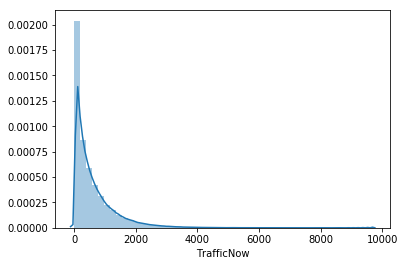

In [8]:
sns.distplot(_train['TrafficNow'])

## 3. Phân chia feature & label

In [10]:
dropHeader = ['TrafficNow']
dataTrainX = _train.drop(dropHeader,axis=1)
dataTrainY = np.asarray(_train['TrafficNow']).reshape(-1,1)
dataTestX = _test.drop(dropHeader,axis=1)
dataTestY = np.asarray(_test['TrafficNow']).reshape(-1,1)

In [11]:
print(dataTrainX.shape, dataTrainY.shape, dataTestX.shape, dataTestY.shape)

(431070, 94) (431070, 1) (9576, 94) (9576, 1)


## 4. Normalization

In [18]:
trainX = dataTrainX.copy()
trainY = dataTrainY.copy()
testX = dataTestX.copy()
testY = dataTestY.copy()
scalarX, scalarY, scalarTX, scalarTY = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
scalarX.fit(trainX)
scalarY.fit(trainY)
scalarTX.fit(testX)
scalarTY.fit(testY)
trainX2 = scalarX.transform(trainX)
trainY2 = scalarY.transform(trainY)
testX2 = scalarTX.transform(testX)
testY2 = scalarTY.transform(testY)

In [19]:
testX2[0:1]

array([[0.19924919, 0.23261246, 0.29684251, 0.27455826, 0.17168786,
        0.13722442, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [20]:
testY2[0:10]

array([[0.1052892 ],
       [0.05708136],
       [0.32498663],
       [0.51463026],
       [0.07629053],
       [0.16525487],
       [0.10760744],
       [0.35251833],
       [0.21477589],
       [0.0333192 ]])

## 5. Shuffle data in train set

In [15]:
ind_list = [i for i in range(trainX2.shape[0])]
shuffle(ind_list)
trainX_new  = trainX2[ind_list,]
trainY_new = trainY2[ind_list,]

## 6. Sử dụng Linear Regression

In [21]:
clf=LinearRegression()
clf.fit(trainX2,trainY2)
accuracy = clf.score(testX2,testY2)
print(accuracy)

0.6071945261740803


In [22]:
predY2 = clf.predict(testX2)

In [23]:
predY2[0:10]

array([[0.19108963],
       [0.12078667],
       [0.37356949],
       [0.38201332],
       [0.16599655],
       [0.21719551],
       [0.16055107],
       [0.39803505],
       [0.16423988],
       [0.13841629]])

In [24]:
testY2[0:10]

array([[0.1052892 ],
       [0.05708136],
       [0.32498663],
       [0.51463026],
       [0.07629053],
       [0.16525487],
       [0.10760744],
       [0.35251833],
       [0.21477589],
       [0.0333192 ]])

In [33]:
predY2inver = scalarTY.inverse_transform(predY2)
np.savetxt('LinearRegressionForm.csv', predY2inver, delimiter=',')
print("MSE - Linear Regression:", mean_squared_error(np.array(testY), predY2inver))

MSE - Linear Regression: 385604.20961975894


## 7. Sử dụng FFNN

In [36]:
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout
# sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# define and fit the final model
model = Sequential()
model.add(Dense(1000, input_dim=94, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.75))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.75))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', # Mean squared error
                optimizer='adam', # Optimization algorithm 
                metrics=['mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              95000     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 870,681
Trainable params: 870,681
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model.fit(trainX2, trainY2, batch_size=512, epochs=5, validation_data=(testX2, testY2))
ypred = model.predict(testX2)
ypredInverse = scalarY.inverse_transform(ypred)
np.savetxt('FFNN.csv', ypredInverse, delimiter=',')
print("MSE - FFNN:",mean_squared_error(np.array(testY), ypredInverse))

Train on 431070 samples, validate on 9576 samples
Epoch 1/5
431070/431070 [==============================] - 7s 16us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/5
431070/431070 [==============================] - 6s 15us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/5
431070/431070 [==============================] - 6s 15us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/5
431070/431070 [==============================] - 6s 15us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/5
431070/431070 [==============================] - 7s 16us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
MSE - FFNN: 348071.8670709091


## 8. Sử dụng GradientBoostingRegressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
est = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

In [43]:
est.fit(trainX2, trainY2)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
predY2GBR = est.predict(testX2)
predY2GBR = predY2GBR.reshape(-1,1)
ynew2 = scalarY.inverse_transform(predY2GBR)
np.savetxt('GBR.csv', ynew2, delimiter=',')   # X is an array
mean_squared_error(np.array(testY), ynew2)

366281.3897410968

## 9. Nhận xét:
Sử dụng các thuật toán khác nhau cho ra độ chính xác (MSE) như sau:
- Linear Regression: **385604.21**
- FFNN: **348071.87**
- GradientBoostingRegressor: **366281.39**

So sánh với cách dự đoán bằng phương pháp tính toán bình thường 

$ TrafficNow = \frac{TrafficBefore1Week + TrafficBefore2Week + TrafficBefore3Week + TrafficBefore4Week + TrafficBefore5Week + TrafficBefore1Day}{6} $

Kêt quả: MSE = **370421.69**

=> Khi so sánh kết quả sử dụng ML và cách tính thông thường chỉ tốt hơn ~ **6-7%**